# Basic Distance Approach

This description of the distance approach closely follows the paper by _Gatev, E., Goetzmann, W. N.,_ and _Rouwenhorst, K. G._ __Pairs Trading: Performance of a Relative Value Arbitrage Rule__  [available here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=141615). 

## Introduction

The distance approach works as follows:
- First, a historical period is defined, cumulative returns for assets in this period are normalized.
- Second, using the Euclidean squared distance on the normalized price time series, $n$ closest pairs of assets are picked.
- After the pairs are formed, the trading period starts, and the trading signals are generated. The mechanism
  behind this process if the following:
  - If the difference between the price of elements in a pair diverged by
    more than 2 standard deviations (calculated for each pair during the training period), the positions are
    opened - long for the element with a lower price in a portfolio and short for an element with a higher price
    in a portfolio.
  - These positions are closed when the normalized prices cross or when the trading period ends.

Using this standard description, the distance approach is a parameter-free strategy.

**Note:** No cointegration tests (as opposed to the mean reversion approach) are being performed in the distance
approach. As spotted in the work by Krauss (2015), dependencies found using this approach can be spurious.
This also leads to higher divergence risks, and as shown in the work by Do and Faff (2010), up to 32% of
pairs identified by this method are not converging.

There are, however, possible adjustments to this strategy, like selecting pairs based on different criteria such as the number of zero crossings or historical variance, choosing distances other than the Euclidean square distance, adjusting the threshold to enter a trade for each pair, etc. 

## Pairs formation step

This stage of the DistanceStrategy consists of the following steps:

1. **Normalization of the input data.**

To use the Euclidean square distance, the training price time series are being normalized using the following
formula:

$$P_{normalized} = \frac{P - min(P)}{max(P) - min(P)}$$

where $P$ is the training price series of an asset, $min(P)$ and $max(P)$ are the minimum and maximum values from the price series.

2. **Finding pairs.**

Using the normalized price series, the distances between each pair of assets are calculated. These
distances are then sorted in the ascending order and the $n$ closest pairs are picked (our
function also allows skipping a number of first pairs, so one can choose pairs 10-15 to study).

The distances between elements (Euclidean square distance - SSD) are calculated as:

$$SSD = \sum^{N}_{t=1} (P^1_t - P^2_t)^{2}$$

where $P^1_t$ and $P^2_t$ are normalized prices at time $t$ for the first and
the second elements in a pair.

Using the prices of elements in a pair a portfolio is being constructed - the difference between
their normalized prices.

3. **Calculating historical volatility.**

For $n$ portfolios (differences between normalized price series of elements) calculated in the
previous step, their volatility is being calculated. Historical standard deviations of these portfolios
will later be used to generate trading signals.

## Pair selection criteria

As basic pairs formation confirms declining profitability in pairs trading, some other refined pair selection criteria have emerged. Here, we describe three different methods from the basic approach in selecting pairs for trading. 

First is only allowing for matching securities within the same industry group. The second is sorting selected pairs based on the number of zero-crossings in the formation period and the third is sorting selected pairs based on the historical standard deviation where pairs with high standard deviation are selected.

1. **Pairs within the same industry group**

In the pairs formation step above, one can add this method when finding pairs in order to match securities within the same industry group. 

With a dictionary containing the name/ticker of the securities and each corresponding industry group, the securities are first separated into different industry groups. Then, by calculating the Euclidean square distance for each of the pair within the same group, the $n$ closest pairs are selected(our function also allows skipping a number of first pairs, so one can choose pairs 10-15 to study). 

This pair selection criterion can be used alongside other methods such as zero-crossings or variance if one gives a dictionary of industry group as an input. This will allow sorting pairs by alternative criteria but within one industry group.

2. **Pairs with a higher number of zero-crossings**

The number of zero crossings in the formation period has a positive relation to the future spread convergence according to the work by Do and Faff (2010). 

After pairs were matched either within the same industry group or from different industries, the top $n$ pairs that had the highest number of zero crossings during the formation period are admitted to the portfolio we select. This method incorporates the time-series dimension of the historical data in the form of the number of zero crossings. 

3. **Pairs with a higher historical standard deviation**

The historical standard deviation calculated in the formation period can also be a criterion to sort selected pairs. 

After pairs were matched, we can sort them based on their historical standard deviation in the formation period. According to the work of Do and Faff(2010), as having a small SSD decreases the variance of the spread, this approach should increase the expected profitability of the method.

4. **Pairs with a cointegrating relationship(Optional)**

For the pairs matched, a cointegration test can also be conducted to select pairs that have cointegrating relationships. 

By using an augmented Engle-Granger two-step cointegration test with a critical value, the pairs having a lower p-value than the critical value are selected. These pairs are expected to have better performance during the trading period, as proposed in the work by Krauss (2017).

## Trading signals generation


After pairs were formed, we can proceed to the second stage of the DistanceStrategy - trading
signals generation. The input to this stage is a dataframe with testing price series for assets - not
used in the pairs formation stage.

This stage of the DistanceStrategy consists of the following steps:

1. **Normalization of the input data.**

Using the same approach as in the pairs formation stage, we normalize the input trading dataset using
the same maximum and minimum historical values from the training price series.

2. **Portfolios creation.**

In this step, the portfolios are being constructed based on the asset pairs chosen in the pairs
formation step. Portfolio values series are differences between normalized price series of elements
in a pair - as we're opening a long position for the first element in a pair and a short position for
the second element in a pair. A buy signal generated by the strategy means going long on the first
element and short on the second. A sell signal means the opposite - going short on the first element
and long on the second element.

3. **Generating signals.**

If the portfolio value exceeds two historical deviations, a sell signal is generated - we expect
the price of the first element to decrease and the price of the second element to increase. And if
the value of the portfolio is below minus two historical deviations, a buy signal is generated.

An open position is closed when the portfolio value crosses the zero mark - or when the prices of
elements in a pair cross. So at any given time, we have one (buy or sell) or none active positions
opened. This makes cost allocation for the strategy easier. Resulting trading signals are target
quantities of portfolios to hold for each pair (with values -1, 0, or +1).

## Results output and plotting

The DistanceStrategy class contains multiple methods to get results in the desired form.

Functions that can be used to get data:

- **get_signals()** outputs generated trading signals for each pair.

- **get_portfolios()** outputs values series of each pair portfolios.

- **get_scaling_parameters()** outputs scaling parameters from the training dataset used to normalize data.

- **get_pairs()** outputs a list of tuples, containing chosen top pairs in the pairs formation step.

- **get_num_crossing()** outputs a list of tuples, containing chosen top pairs with its number of zero-crossings.

Functions that can be used to plot data:

- **plot_pair()** plots normalized price series for elements in a given pair and the corresponding
  trading signals for portfolio of these elements.

- **plot_portfolio()** plots portfolio value for a given pair and the corresponding trading signals.

## Usage of the Algorithms

Let's use the above strategy on real data. 

First, we will choose a training period of 12 months to form pairs. Second, we'll create trading signals for the following 6 months window. Finally, we will analyze the obtained results. 

In [1]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 

### Loading data

As a dataset, we'll download the price time series for 272 stocks over a period from 01.2018 to 07.2019. First 12 months of data will be used for training and the following 6 months for trading signal generation and analysis of results. 

Also, for industry-group based selection, we’ll use 4 major industries in S&P 500 stocks: Information Technology, Industrials, Financials and Healthcare. We’ll download this data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) but any source of data can be used if we follow the dictionary style as below.

In [2]:
# Get industry data from Wikipedia 
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_table = table[0]

# Indutry groups to use are below
industry_group = ['Information Technology','Industrials','Financials',
                  'Health Care']

# Get tickers from S&P 500 which are in those industry groups
ticker_industry = stock_table[stock_table['GICS Sector']
                              .isin(industry_group)].reset_index(drop=True)

# Get a dataframe of ticker and industry group
ticker_industry = ticker_industry[['Symbol','GICS Sector']]

# Get tickers to use as a list
tickers = ticker_industry['Symbol'].to_list()
remove_tickers = ['CARR','ABC','BRK.B','VNT','OTIS'] # Removed tickers
tickers = [ticker for ticker in tickers if ticker not in remove_tickers]

# Get a dictionary of industry group
industry_dict = pd.Series(ticker_industry['GICS Sector'].values,
                          index=ticker_industry['Symbol']).to_dict()

# Loading data
train_data =  yf.download(tickers, start="2018-01-03", end="2019-01-01")
test_data =  yf.download(tickers, start="2019-01-02", end="2019-07-01")

# Taking close prices for chosen instruments
train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

# Looking at the downloaded data
train_data.head()

[*********************100%***********************]  272 of 272 completed
[*********************100%***********************]  272 of 272 completed


,A,AAL,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADP,...,WRB,WST,WU,XLNX,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.877853,51.647556,41.156406,83.965569,192.490005,55.684303,146.372726,177.699997,84.586998,108.099258,...,44.051796,98.066849,16.841452,64.657593,65.490776,65.376862,121.132782,103.709999,46.290783,70.380058
2018-01-03,67.554039,51.014027,41.149239,85.279503,195.820007,55.807426,147.048264,181.039993,85.636383,109.273544,...,43.687008,98.185112,16.832628,65.953041,65.266426,66.174019,121.972481,105.769997,46.236004,70.703651
2018-01-04,67.047279,51.335667,41.340389,84.793175,199.250000,55.712711,148.789413,183.220001,85.542686,110.317375,...,43.863110,98.155556,17.168045,67.143723,65.256653,66.615829,121.796738,107.860001,46.427734,71.125328
2018-01-05,68.119247,51.316177,41.811058,86.269249,202.320007,55.873722,150.016815,185.339996,85.889336,110.252121,...,43.680729,99.387543,18.183119,70.629974,66.173569,66.490967,123.007484,109.540001,46.445999,71.939262
2018-01-08,68.265442,50.809345,41.655762,84.887016,207.800003,55.712711,151.215637,185.039993,86.039261,109.916618,...,43.460594,99.949333,18.968700,71.096703,66.622284,66.731087,123.241814,110.629997,46.217739,72.802223


### Forming pairs

Now let's form pairs and calculate historical volatilities for chosen portfolio pairs based on training data.

In [3]:
# Initialising an object containing needed methods
strategy = al.distance_approach.DistanceStrategy()

# Performing the pairs formation step and picking top 20 pairs
strategy.form_pairs(train_data, num_top=20)

# Getting scaling values used to normalize data, a list of created pairs and historical volatility for each chosen pair portfolio
scaling_parameters = strategy.get_scaling_parameters()
pairs = strategy.get_pairs()
historical_std = strategy.train_std

In [4]:
# Looking at the scaling parameters 
scaling_parameters

,min_value,max_value
A,59.715416,73.261055
AAL,29.247076,56.988728
AAPL,35.607342,56.082977
ABBV,69.013512,105.879532
ABMD,192.490005,449.750000
...,...,...
XYL,59.650597,79.306740
ZBH,95.530594,129.172165
ZBRA,103.709999,182.479996
ZION,35.861076,53.879093


These scaling parameters can be used to calculate weights for elements when creating a portfolio.

In [5]:
# Looking at top closest pairs 
pairs

[('ISRG', 'V'),
 ('HBAN', 'KEY'),
 ('MTB', 'PNC'),
 ('LNC', 'PRU'),
 ('CMA', 'RF'),
 ('PFG', 'PRU'),
 ('BLK', 'STT'),
 ('FBHS', 'MAS'),
 ('MSFT', 'V'),
 ('LLY', 'PFE'),
 ('ISRG', 'MSFT'),
 ('AIG', 'HIG'),
 ('AMP', 'LNC'),
 ('INTU', 'MA'),
 ('CFG', 'GS'),
 ('CFG', 'PNC'),
 ('CFG', 'MTB'),
 ('LLY', 'MRK'),
 ('ADBE', 'MA'),
 ('KEY', 'RF')]

For example, if we have a pair portfolio of ('MSFT', 'V'), we can construct series of their normalized prices as:

In [6]:
# Normalizing the price series on our own (already done inside the DistanceStrategy class)
MSFT_series_scaled = (train_data['MSFT'] - scaling_parameters['min_value']['MSFT']) / \
                  (scaling_parameters['max_value']['MSFT'] - scaling_parameters['min_value']['MSFT'])

V_series_scaled = (train_data['V'] - scaling_parameters['min_value']['V']) / \
                   (scaling_parameters['max_value']['V'] - scaling_parameters['min_value']['V'])

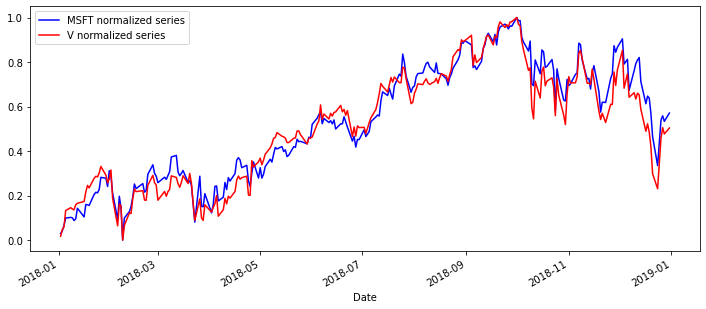

In [7]:
# Plotting the results
plt.figure(figsize=(12,5))

ax1 = MSFT_series_scaled.plot(color='blue', label='MSFT normalized series')
ax2 = V_series_scaled.plot(color='red', label='V normalized series')

plt.legend()
plt.show()

In [8]:
# Looking at top closest pairs 
pairs

[('ISRG', 'V'),
 ('HBAN', 'KEY'),
 ('MTB', 'PNC'),
 ('LNC', 'PRU'),
 ('CMA', 'RF'),
 ('PFG', 'PRU'),
 ('BLK', 'STT'),
 ('FBHS', 'MAS'),
 ('MSFT', 'V'),
 ('LLY', 'PFE'),
 ('ISRG', 'MSFT'),
 ('AIG', 'HIG'),
 ('AMP', 'LNC'),
 ('INTU', 'MA'),
 ('CFG', 'GS'),
 ('CFG', 'PNC'),
 ('CFG', 'MTB'),
 ('LLY', 'MRK'),
 ('ADBE', 'MA'),
 ('KEY', 'RF')]

These pairs will be used during the trading signal generation stage.

In [9]:
# Looking at historical standard deviations of pair portfolios
historical_std

{('ISRG', 'V'): 0.04294991504265647,
 ('HBAN', 'KEY'): 0.056019160751495406,
 ('MTB', 'PNC'): 0.05644561652249269,
 ('LNC', 'PRU'): 0.04757825034918941,
 ('CMA', 'RF'): 0.055896804143757035,
 ('PFG', 'PRU'): 0.056088758347718135,
 ('BLK', 'STT'): 0.057496896638297414,
 ('FBHS', 'MAS'): 0.055602099000644264,
 ('MSFT', 'V'): 0.059315348889243495,
 ('LLY', 'PFE'): 0.06259118550750681,
 ('ISRG', 'MSFT'): 0.06500364639992119,
 ('AIG', 'HIG'): 0.06528854925847453,
 ('AMP', 'LNC'): 0.06546741366720428,
 ('INTU', 'MA'): 0.06782823713051556,
 ('CFG', 'GS'): 0.06690521624242504,
 ('CFG', 'PNC'): 0.06907973152946571,
 ('CFG', 'MTB'): 0.07148590720291788,
 ('LLY', 'MRK'): 0.06767517183904777,
 ('ADBE', 'MA'): 0.06534809435097574,
 ('KEY', 'RF'): 0.07201313290609436}

Generally, we can observe that with the increase of Euclidean distance between pairs the volatility is also rising.

### Alternative pair selection methods

As basic pairs formation confirms declining profitability in pairs trading, some other refined pair selection criteria have emerged. Here, we describe three different methods from the basic approach in selecting pairs for trading.

First is only allowing for matching securities within the same industry group. The second is sorting selected pairs based on the number of zero-crossings in the formation period and the third is sorting selected pairs based on the historical standard deviation where pairs with high standard deviation are selected.

Now let’s make strategies for each of the selection method. 

In [10]:
# Defining three different pair selection criteria 
strategy_industry = al.distance_approach.DistanceStrategy()
strategy_zero_crossing = al.distance_approach.DistanceStrategy()
strategy_variance = al.distance_approach.DistanceStrategy()

# Performing the pairs formation step and picking top 20 pairs
strategy_industry.form_pairs(train_data, industry_dict=industry_dict, 
                             num_top=20)
strategy_zero_crossing.form_pairs(train_data, method='zero_crossing', 
                             industry_dict=industry_dict, num_top=20)
strategy_variance.form_pairs(train_data, method='variance',
                             industry_dict=industry_dict, num_top=20)

# Getting a list of created pairs for each of the strategy
pairs_industry = strategy_industry.get_pairs()
pairs_zero_crossing = strategy_zero_crossing.get_pairs()
pairs_variance = strategy_variance.get_pairs()

# Getting scaling values used to normalize data
scaling_industry = strategy_industry.get_scaling_parameters()
scaling_zero_crossing = strategy_zero_crossing.get_scaling_parameters()
scaling_variance = strategy_variance.get_scaling_parameters()

**(Optional) Cointegration Test**

For the pairs selected, we’ll conduct a cointegration test to see which pairs are actually cointegrated, as these pairs may perform better during the trading period. We’ll use the augmented Engle-Granger two-step cointegration test here and as the results of the test only belong to the data we selected, one may perform different tests on different datasets.

A brief introduction to Engle-Granger two-step cointegration test method is in below.

For two stocks in a pair, let’s say stock 1 and stock 2, as we do not know $\beta$, we estimate it by using ordinary least squares, and then run the stationarity test on the estimated $u_{t}$ series. 

$$stock1_{t}-\beta stock2_{t}=u_{t}$$

Here, by using a module from [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html), the Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the p-value is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

Below is a simple function returning a list containing tuples of two strings that are cointegrated. One may use the function to test the cointegration of the pairs. There is also a cointegration module in our Arbitrage Lab so we highly recommend reading [here](https://hudson-and-thames-arbitragelab.readthedocs-hosted.com/en/latest/cointegration_approach/cointegration_tests.html) and utilize it as well.

In [11]:
def get_coint_pairs(pairs, train_data, critical_val = 0.05):
    """
    Selects pairs which are cointegrated at the given critical values only.

    For cointegration test, Engle-Granger two-step cointegration test is used.

    :param pairs: (list) List containing tuples of two strings, for names of elements in a pair.
    :param train_data: (pd.DataFrame) Dataframe with training data used to create asset pairs.
    :param critical_val: (float) Critical value to reject the null hypothesis. By default, it's 0.05.
    :return: (list) List containing tuples of two strings that are cointegrated.
    """

    # Make an empty list for cointegrated pairs
    pairs_coint = []

    # Perform hypothesis test for every pair in the pairs list
    for pair in pairs:

        # Select each stock in the pair
        first_ticker = pair[0]
        second_ticker = pair[1]

        # Get data for each of the stock with scaling parameter
        first_stock = train_data[first_ticker].fillna(method='ffill')

        second_stock = train_data[second_ticker].fillna(method='ffill')

        # Conduct a cointegration test and get p-value
        p_value = ts.coint(first_stock.values, second_stock.values)[1]

        # Check whether the p-value is below the critical value and add to a list if it is.
        if p_value < critical_val:
            pairs_coint.append(pair)

    return pairs_coint

Pairs that have a cointegrating relationship in standard strategy.

In [12]:
get_coint_pairs(pairs, train_data)

[('ISRG', 'V'),
 ('HBAN', 'KEY'),
 ('MTB', 'PNC'),
 ('PFG', 'PRU'),
 ('BLK', 'STT'),
 ('FBHS', 'MAS'),
 ('ISRG', 'MSFT'),
 ('CFG', 'GS'),
 ('LLY', 'MRK')]

Pairs that have a cointegrating relationship within the same industry.

In [13]:
get_coint_pairs(pairs_industry, train_data)

[('HBAN', 'KEY'),
 ('MTB', 'PNC'),
 ('PFG', 'PRU'),
 ('BLK', 'STT'),
 ('FBHS', 'MAS'),
 ('CFG', 'GS'),
 ('LLY', 'MRK'),
 ('BAC', 'KEY')]

### Generating trading signals

Now let's generate trading signals for the testing dataset.

We are testing the standard strategy here but strategies using other methods can also be used if one changes the original strategy to other strategies in the codes below.

In [14]:
# Performing the signal generation stage using (2 * st. variation) as a threshold
strategy.trade_pairs(test_data, divergence=2)

# Getting series of portfolio values, trading signals, and normalized price series of elements for each chosen pair
portfolio_series = strategy.get_portfolios()
trading_signals = strategy.get_signals()
normalized_prices = strategy.normalized_data

In [15]:
# Looking at calculated portfolio value series
portfolio_series.head()

,"('ISRG', 'V')","('HBAN', 'KEY')","('MTB', 'PNC')","('LNC', 'PRU')","('CMA', 'RF')","('PFG', 'PRU')","('BLK', 'STT')","('FBHS', 'MAS')","('MSFT', 'V')","('LLY', 'PFE')","('ISRG', 'MSFT')","('AIG', 'HIG')","('AMP', 'LNC')","('INTU', 'MA')","('CFG', 'GS')","('CFG', 'PNC')","('CFG', 'MTB')","('LLY', 'MRK')","('ADBE', 'MA')","('KEY', 'RF')"
2019-01-02,-0.074526,0.024415,-0.025376,-0.070346,-0.005806,-0.025300,0.037366,-0.043707,0.026895,0.140111,-0.101420,-0.041827,0.069671,0.006424,-0.000598,-0.046548,-0.021172,0.038534,-0.054390,-0.000839
2019-01-03,-0.025649,-0.002913,-0.032282,-0.058057,-0.015916,-0.025133,0.025436,-0.040905,0.037012,0.152822,-0.062662,-0.039424,0.052892,0.049342,0.014038,-0.043120,-0.010838,0.019429,-0.026897,0.008363
2019-01-04,-0.065716,0.003015,-0.015601,-0.062701,-0.023738,-0.048124,0.043330,-0.070118,0.033057,0.153929,-0.098773,-0.062955,0.043697,0.025505,0.032038,-0.036212,-0.020611,0.008294,-0.038100,0.003446
2019-01-07,-0.096244,-0.006986,0.021274,-0.054088,-0.039723,-0.036634,0.032656,-0.091347,-0.027238,0.150246,-0.069006,-0.044899,0.042362,0.043174,0.044303,-0.010002,-0.031276,0.053179,-0.026866,-0.009762
2019-01-08,-0.093216,0.019411,0.028671,-0.077951,-0.055435,-0.063548,0.050216,-0.103223,-0.023562,0.158305,-0.069654,-0.004258,0.063805,0.084297,0.050001,-0.013831,-0.042502,0.055112,-0.011120,-0.032088


In [16]:
# Looking at generated trading signals - target quantities of portfolios to hold
trading_signals.head()

,"('ISRG', 'V')","('HBAN', 'KEY')","('MTB', 'PNC')","('LNC', 'PRU')","('CMA', 'RF')","('PFG', 'PRU')","('BLK', 'STT')","('FBHS', 'MAS')","('MSFT', 'V')","('LLY', 'PFE')","('ISRG', 'MSFT')","('AIG', 'HIG')","('AMP', 'LNC')","('INTU', 'MA')","('CFG', 'GS')","('CFG', 'PNC')","('CFG', 'MTB')","('LLY', 'MRK')","('ADBE', 'MA')","('KEY', 'RF')"
2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Also normalized price series for each asset
normalized_prices.head()

,A,AAL,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADP,...,WRB,WST,WU,XLNX,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.361332,0.097906,0.131347,0.242466,0.456620,0.745578,0.177699,0.479293,0.361133,0.537443,...,0.469747,0.329165,0.140196,0.762100,0.109035,0.253634,0.154532,0.666878,0.158665,0.554665
2019-01-03,0.185614,0.012061,-0.054955,0.172798,0.426806,0.570631,0.054440,0.388588,0.141069,0.449924,...,0.378846,0.283148,0.076038,0.662108,0.109633,0.140907,0.100374,0.548051,0.146778,0.432676
2019-01-04,0.344631,0.082298,0.016936,0.238675,0.470147,0.671440,0.190025,0.495859,0.224176,0.561940,...,0.462172,0.373957,0.128314,0.780446,0.142482,0.274892,0.200786,0.625365,0.212415,0.566361
2019-01-07,0.445560,0.114579,0.013028,0.269481,0.475433,0.725844,0.202608,0.527252,0.246225,0.546128,...,0.478079,0.381546,0.116434,0.851083,0.163386,0.225947,0.201957,0.654818,0.221201,0.587668
2019-01-08,0.516719,0.095778,0.046427,0.279434,0.489505,0.681574,0.294539,0.562225,0.332300,0.563275,...,0.437932,0.458403,0.123562,0.798794,0.155323,0.256599,0.133747,0.668021,0.241357,0.640724


The DistanceStrategy class also allows plotting data for a chosen pair. Looking again at the list of chosen pairs to pick a pair to plot.

In [18]:
# Looking at top closest pairs 
pairs

[('ISRG', 'V'),
 ('HBAN', 'KEY'),
 ('MTB', 'PNC'),
 ('LNC', 'PRU'),
 ('CMA', 'RF'),
 ('PFG', 'PRU'),
 ('BLK', 'STT'),
 ('FBHS', 'MAS'),
 ('MSFT', 'V'),
 ('LLY', 'PFE'),
 ('ISRG', 'MSFT'),
 ('AIG', 'HIG'),
 ('AMP', 'LNC'),
 ('INTU', 'MA'),
 ('CFG', 'GS'),
 ('CFG', 'PNC'),
 ('CFG', 'MTB'),
 ('LLY', 'MRK'),
 ('ADBE', 'MA'),
 ('KEY', 'RF')]

Let's look at normalized prices, portfolio values and generated trading signals for the pair ('CMA', 'RF') - with number 4 (counting from zero).

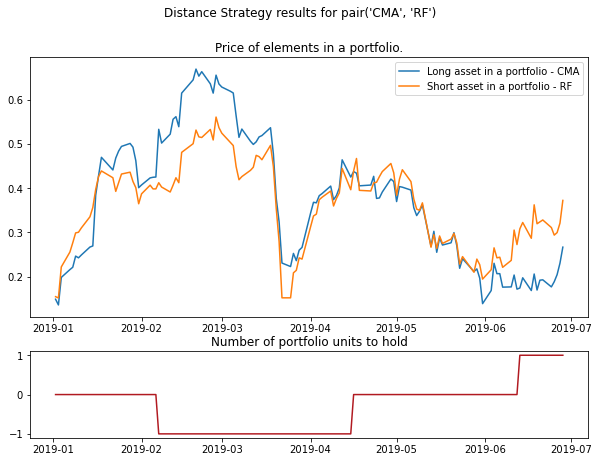

In [19]:
# Plotting normalized price series of elements in a pair
figure_pair = strategy.plot_pair(4)

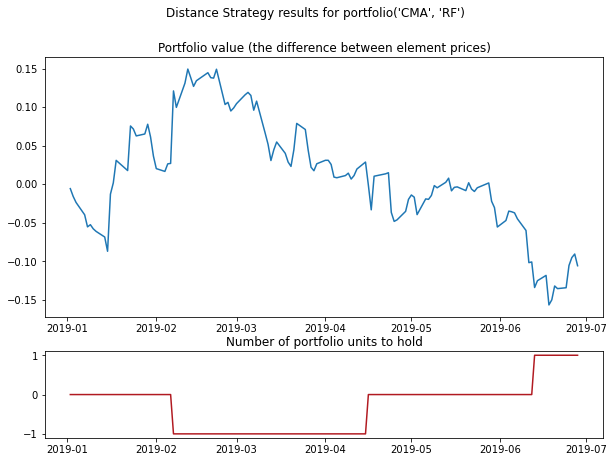

In [20]:
# Plotting portfolio value series
figure_portfolio = strategy.plot_portfolio(4)

This pair of stocks is moving similarly over the testing period. A signal to open a sell position on a portfolio is generated in the middle of February 2019 and a signal to close this position is generated around April of 2019.

As the long asset in a portfolio is 'CMA' and the short asset is 'RF', the signal to sell a portfolio means we should sell 'CMA' and buy 'RF'.

We can either buy and sell one share for each asset in a pair or calculate weights for 'CMA' and 'RF' based on starting prices and scaling parameters.

First, we should scale by starting prices of each stock and next by scaling parameters ($max(P) - min(P)$) (returns are proportional to initial prices of stocks and negatively proportional to the scaling parameter):

- $Scale_{1} = \frac{P_{1}^{0}}{P_{1}^{0} + P_{2}^{0}} * \frac{(max(P_{2}) - min(P_{2})}{(max(P_{1}) - min(P_{1})) + (max(P_{2}) - min(P_{2}))}$

- $Scale_{2} = \frac{P_{2}^{0}}{P_{1}^{0} + P_{2}^{0}} * \frac{(max(P_{1}) - min(P_{1})}{(max(P_{1}) - min(P_{1})) + (max(P_{2}) - min(P_{2}))}$


In [21]:
# Looking at the scaling parameters (min and max values) used for elements in a portfolio
pair_scales = scaling_parameters.loc[['CMA', 'RF']]

pair_scales

,min_value,max_value
CMA,57.511585,89.291298
RF,11.457900,17.954258


In [22]:
# So the scaling parameters for 'CMA' and 'RF' are
maxmin_CMA = pair_scales.loc['CMA'][1] - pair_scales.loc['CMA'][0]
maxmin_RF = pair_scales.loc['RF'][1] - pair_scales.loc['RF'][0]

scale_CMA = (test_data['CMA'][0] / (test_data['CMA'][0] + test_data['RF'][0])) * (maxmin_RF / (maxmin_CMA + maxmin_RF))
scale_RF = (test_data['RF'][0] / (test_data['CMA'][0] + test_data['RF'][0])) * (maxmin_CMA / (maxmin_CMA + maxmin_RF))

print('Scaling parameter for CMA is ', scale_CMA)
print('Scaling parameter for RF is ', scale_RF)

Scaling parameter for CMA is  0.1414096394682647
Scaling parameter for RF is  0.13851053837811222


Now, let's check how much profit would this distance strategy generate on a given ('CMA', 'RF') pair.

In [23]:
# Returns of elemrnts in a test dataset
test_data_returns = (test_data / test_data.shift(1) - 1)[1:]

test_data_returns.head()

,A,AAL,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADP,...,WRB,WST,WU,XLNX,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.036840,-0.074507,-0.099607,-0.032949,-0.024745,-0.047194,-0.034142,-0.039498,-0.060405,-0.030198,...,-0.016570,-0.019500,-0.015753,-0.037651,0.000528,-0.034281,-0.018088,-0.059908,-0.005532,-0.034565
2019-01-04,0.034613,0.065868,0.042689,0.032217,0.036885,0.028541,0.038884,0.048632,0.024278,0.039854,...,0.015445,0.039247,0.013041,0.046303,0.029016,0.042192,0.034153,0.041462,0.030713,0.039235
2019-01-07,0.021234,0.028402,-0.002226,0.014595,0.004339,0.014976,0.003474,0.013573,0.006288,-0.005410,...,0.002904,0.003156,-0.002925,0.026415,0.017944,-0.014789,0.000385,0.015166,0.003989,0.006017
2019-01-08,0.014660,-0.016085,0.019063,0.004648,0.011499,-0.012006,0.025290,0.014918,0.024396,0.005899,...,-0.007307,0.031862,0.001760,-0.019051,-0.006799,0.009401,-0.022425,0.006697,0.009114,0.014894
2019-01-09,0.020935,0.030845,0.016982,-0.032823,0.056466,0.016691,0.005029,0.011819,0.025340,0.000914,...,0.002778,0.020651,0.014646,0.008972,0.005325,0.016224,0.008172,0.024819,0.008569,-0.003582


For unscaled portfolio we'll invest 50% into the 'CMA' asset and 50% in the 'RF' asset. 

For scaled portfolio we should calculate the weights - make scales for 'CMA' and 'RF' sum up to 1.

In [24]:
weight_CMA = scale_CMA / (scale_CMA + scale_RF)
weight_RF = 1 - weight_CMA

print("For scaled portfolio we'll invest ", round(weight_CMA, 3), "% into the CMA asset.")
print("And ", round(weight_RF, 3), "% into the RF asset.")

For scaled portfolio we'll invest  0.505 % into the CMA asset.
And  0.495 % into the RF asset.


Let's test that weight parameters are calculated right

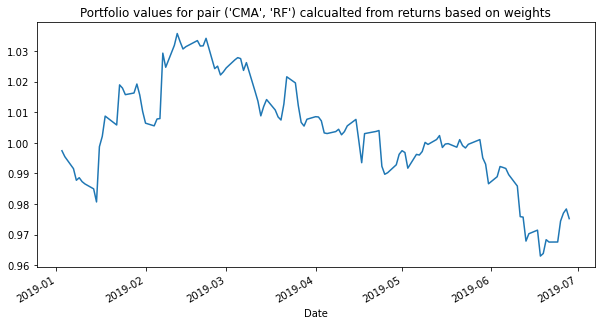

In [25]:
# Pair portfolio price from returns using weight parameters
pair_portfolio_returns = test_data_returns['CMA'] * weight_CMA - test_data_returns['RF'] * weight_RF
pair_portfolio_price = (pair_portfolio_returns + 1).cumprod()
pair_portfolio_price.plot(title="Portfolio values for pair ('CMA', 'RF') calcualted from returns based on weights", figsize=(10,5));

As we can see, this price performance matches the pair portfolio price performance from the DistanceStrategy class plot_portfolio() function. 

In [26]:
# Invested portfolio prices for scaled and unscaled weights
portfolio_returns_unscaled = test_data_returns['CMA'] * 0.5 - test_data_returns['RF'] * 0.5
portfolio_returns_unscaled = portfolio_returns_unscaled * (trading_signals["('CMA', 'RF')"].shift(1))
portfolio_price_unscaled = (portfolio_returns_unscaled + 1).cumprod()

portfolio_returns_scaled = test_data_returns['CMA'] * weight_CMA - test_data_returns['RF'] * weight_RF
portfolio_returns_scaled = portfolio_returns_scaled * (trading_signals["('CMA', 'RF')"].shift(1))
portfolio_price_scaled = (portfolio_returns_scaled + 1).cumprod()

Investment portfolio value rose to  1.035202354401411


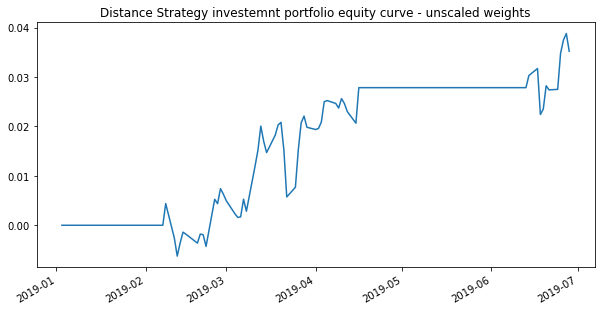

In [27]:
# Equity curve of our unscaled portfolio price
equity_curve_unscaled = portfolio_price_unscaled - 1

equity_curve_unscaled.plot(title='Distance Strategy investemnt portfolio equity curve - unscaled weights', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_price_unscaled[-1])

Investment portfolio value rose to  1.0357182075284181


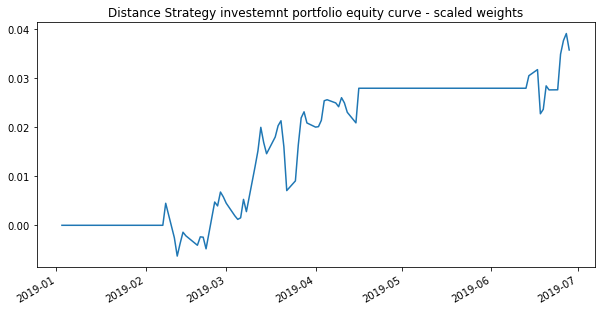

In [28]:
# Equity curve of our scaled portfolio price
equity_curve_scaled = portfolio_price_scaled - 1

equity_curve_scaled.plot(title='Distance Strategy investemnt portfolio equity curve - scaled weights', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_price_scaled[-1])

So using trading signals from the Distance Strategy for this particular example resulted in the equity curve of our investment portfolio increasing from 1 in mid-January 2019 to around 1.0357 in late May 2019 for the scaled portfolio and 1.0352 for the unscaled one.

## Conclusion

This notebook describes the Distance Strategy class and its functionality. Also, it shows how the stages of the method (pairs formation and trading signals generation) can be used on real data and that this method can output profitable trading signals.

The algorithms and the descriptions used in this notebook were described by _Gatev, E., Goetzmann, W. N.,_ and _Rouwenhorst, K. G._ in the paper __Pairs Trading: Performance of a Relative Value Arbitrage Rule__  [available here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=141615).

Key takeaways from the notebook:
- The distance approach can be divided into two stages - pairs formation and trading signals generation.
- The distance approach works as follows:
  - First, a historical period is defined, cumulative returns for assets in this period are normalized.
  - Second, using the Euclidean squared distance on the normalized price time series, $n$ closest pairs of assets are picked.
  - During the treading period, the trading signals are generated. The mechanism behind this process is the following:
  - If the difference between the price of elements in a pair diverged by
    more than 2 standard deviations (calculated for each pair during the training period), the positions are
    opened - long for the element with a lower price in a portfolio and short for an element with a higher price
    in a portfolio.
  - These positions are closed when the normalized prices cross or when the trading period ends.
- Other refined pair selection criteria have emerged:
  - First is only allowing for matching securities within the same industry group.
  - The second is sorting selected pairs based on the number of zero-crossings in the formation period.
  - The third is sorting selected pairs based on the historical standard deviation where pairs with high standard deviation     are selected.
- No cointegration tests are being performed in the distance approach by default, so dependencies found using this approach can be spurious.
- We show how a cointegration test can also be conducted to select pairs that have cointegrating relationships. These pairs are expected to have better performance during the trading period.

## References ##
- [Gatev, E., Goetzmann, W.N. and Rouwenhorst, K.G., 2006. Pairs trading: Performance of a relative-value arbitrage rule. The Review of Financial Studies, 19(3), pp.797-827.](https://www.stat.rutgers.edu/home/hxiao/fsrm588_2013/gatev.pdf)
- [Do, B. and Faff, R., 2012. Are pairs trading profits robust to trading costs?. Journal of Financial Research, 35(2), pp.261-287.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1707125)
- [Do, B. and Faff, R., 2010. Does simple pairs trading still work?. Financial Analysts Journal, 66(4), pp.83-95](https://www.jstor.org/stable/25741293?seq=1)
- [Krauss, C., 2017. Statistical arbitrage pairs trading strategies: Review and outlook. Journal of Economic Surveys, 31(2), pp.513-545.](https://www.econstor.eu/bitstream/10419/116783/1/833997289.pdf)